<a href="https://colab.research.google.com/github/akhilvydyula/Restaurant-Rating-Predict/blob/main/EDA_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/

 Akhil-T-CV.gdoc		     RE-AKHIL.gdoc
'Colab Notebooks'		     RE-AKHIL.pdf
'Copy of final_model.ipynb'	    'Restaurant '
'FDI Case Study.gsheet'		     Resume.gdoc
 kaggle_movie_train.csv		     SCIENCE_BOORLA.gslides
'mng-vbsx-yuf - Apr 24, 2021.gjam'  'Thyroid '
'Mushroom '			    'Transfer Learning Resnet 50.ipynb'
 news				     Untitled
'RE-AKHIL (1).pdf'		    'Untitled document.gdoc'
'RE-AKHIL (2).pdf'		    'Untitled spreadsheet.gsheet'
'RE-AKHIL (3).pdf'		    'Vehicle '


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.regression.linear_model import OLS
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

zomato = pd.read_csv("/content/drive/MyDrive/Restaurant /zomato.csv", na_values = ["-", ""])
# Making a copy of the data to work on
data = zomato.copy()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data.shape
# The dataset has 51717 rows and 17 columns

(51717, 17)

In [5]:
data.info()
# Each row represents a restaurant and each column is a feature of the restaurant

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43873 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [6]:
data.head(3)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari


In [7]:
data.tail(3)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
51714,https://www.zomato.com/bangalore/plunge-sherat...,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Plunge - Sheraton Grand Bengaluru Whitefield H...,No,No,NaN,0,NaN,Whitefield,Bar,NaN,Finger Food,"2,000",[],[],Pubs and bars,Whitefield
51715,https://www.zomato.com/bangalore/chime-sherato...,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3 /5,236,080 49652769,"ITPL Main Road, Whitefield",Bar,"Cocktails, Pizza, Buttermilk",Finger Food,"2,500","[('Rated 4.0', 'RATED\n Nice and friendly pla...",[],Pubs and bars,Whitefield
51716,https://www.zomato.com/bangalore/the-nest-the-...,"ITPL Main Road, KIADB Export Promotion Industr...",The Nest - The Den Bengaluru,No,No,3.4 /5,13,+91 8071117272,"ITPL Main Road, Whitefield","Bar, Casual Dining",NaN,"Finger Food, North Indian, Continental","1,500","[('Rated 5.0', 'RATED\n Great ambience , look...",[],Pubs and bars,Whitefield


### Observations
- The dataset contains missing values
- Location information is captured more accurately by "location" than by "listed_in(city)"
- There is some information overlap between rest_type and listed_in(type) 
- There's something strange about the menu_item column - let's take a closer look

In [8]:
data["menu_item"].value_counts()[:1]

[]    39617
Name: menu_item, dtype: int64

39617 entries in the column are empty lists [] 

In [9]:
data.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7844
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

It appears both menu_item and dish_liked have over 50% of their data missing.

In [10]:
data.address[1]

'2nd Floor, 80 Feet Road, Near Big Bazaar, 6th Block, Kathriguppe, 3rd Stage, Banashankari, Bangalore'

Zip codes are not included in the addresses. So they may not be useful for analysis but can be used to identify duplicate data.

In [11]:
# Renaming and removing commas in the cost column 
data = data.rename({"approx_cost(for two people)": "cost"}, axis=1)
data["cost"] = data["cost"].replace(",", "", regex = True)

In [12]:
# Converting numeric columns to their appropriate dtypes
data[["votes", "cost"]] = data[["votes", "cost"]].apply(pd.to_numeric)

In [13]:
# Examining restaurant types in the column "listed_in(type)"
data["listed_in(type)"].value_counts()

Delivery              25942
Dine-out              17779
Desserts               3593
Cafes                  1723
Drinks & nightlife     1101
Buffet                  882
Pubs and bars           697
Name: listed_in(type), dtype: int64

In [14]:
# Examining the top 20 restaurant types in the column "rest_type"
data["rest_type"].value_counts()[:10]

Quick Bites           19132
Casual Dining         10330
Cafe                   3732
Delivery               2604
Dessert Parlor         2263
Takeaway, Delivery     2037
Casual Dining, Bar     1154
Bakery                 1141
Beverage Shop           867
Bar                     697
Name: rest_type, dtype: int64

There is an information overlap between these two features and we can see that rest_type is more informative. Additionally, the uploader has mentioned there is duplication of data because many restaurants are categorised under multiple types in listed_in(type). We will handle this duplication before proceeding further.

In [15]:
# Group and aggregate duplicate restaurants that are listed under multiple types in listed_in(type)

grouped = data.groupby(["name", "address"]).agg({"listed_in(type)" : list})
newdata = pd.merge(grouped, data, on = (["name", "address"]))

In [16]:
# Examine the duplicates
newdata.head(3)
# The duplicates can be seen in column "listed_in(type)_x"

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,listed_in(type)_y,listed_in(city)
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200.0,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Bellandur
1,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4 /5,7,+91 9108342079\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200.0,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Sarjapur Road
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400.0,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,BTM


In [17]:
# Drop rows which have duplicate information in "name", "address" and "listed_in(type)_x"
newdata["listed_in(type)_x"] = newdata["listed_in(type)_x"].astype(str) # converting unhashable list to a hashable type
newdata.drop_duplicates(subset = ["name", "address", "listed_in(type)_x"], inplace = True)

In [18]:
newdata.shape

(12499, 18)

The reduced dataset has 12499 restaurants - **a substantial reduction from 51717 !**

In [19]:
newdata.describe(include = "all")

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,listed_in(type)_y,listed_in(city)
count,12499,12499,12499,12499,12499,12499,10088,12499.000000,12232,12490,12436,4608,12480,12440.00000,12499,12499,12499,12499
unique,8792,11495,927,12499,2,2,60,NaN,10898,93,93,4277,2609,NaN,9966,2279,7,30
top,Cafe Coffee Day,Delivery Only,"['Delivery', 'Dine-out']",https://www.zomato.com/bangalore/feeltheroll-b...,Yes,No,NEW,NaN,080 43334333,Whitefield,Quick Bites,Biryani,North Indian,NaN,[],[],Delivery,BTM
freq,54,33,1209,1,6604,11550,772,NaN,79,885,5024,47,745,NaN,2511,10201,8715,1456
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.683815,NaN,NaN,NaN,NaN,NaN,487.20000,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.711621,NaN,NaN,NaN,NaN,NaN,390.85198,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,40.00000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,250.00000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,400.00000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.000000,NaN,NaN,NaN,NaN,NaN,600.00000,NaN,NaN,NaN,NaN


## Observations
- There are 8792 unique restaurant names, of which **Cafe Coffee Day** has the highest occurrence (54)
- There are 93 unique locations in Bangalore of which **Whitefield** has the highest number of restaurants (885). Note that this is different from the original dataset's "top" location, BTM, which shows the importance of removing duplicates
- The most common restaurant type is "Quick Bites" (5024 occurrences)
- The most common listed type is Delivery (8715) 
- Biryani is the most popular dish, but we can't be sure about this as dish_liked is missing over half its data
- There are 2609 unique levels in the cuisines column, this is because restaurants are categorised under many different combinations of cuisines
- Average cost for two at Bangalore restaurants is Rs 487 and there is very **high variance** (standard deviation Rs 390)
- Average number of votes per restaurant is 180 and here too there is **high variance**
- Majority of restaurants allow online ordering but don't allow online table booking
- NEW is the most common entry in the rating column - this represents unrated new restaurants. We will look at the ratings more closely later
- Like menu_item, reviews_list also contains many empty lists (2511)


In [20]:
# Converting the restaurant names to rownames 
newdata.index = newdata["name"]

In [21]:
# Identifying the top 10 cuisines in Bangalore?
pd.DataFrame(newdata.groupby(["cuisines"])["cuisines"].agg(['count']).sort_values("count", ascending = False)).head(10)

,count
cuisines,
North Indian,745
South Indian,612
"North Indian, Chinese",571
Biryani,274
"Bakery, Desserts",254
Fast Food,241
"South Indian, North Indian, Chinese",200
Bakery,196
Desserts,183


Despite being a southern city, Bangalore has **more North Indian restaurants than South Indian**. Bangaloreans also really seem to love their biryani as no other dish has an entire cuisine category to itself.

In [22]:
# Dropping unnecessary columns
newdata.drop(["name", "url", "phone", "listed_in(city)", "listed_in(type)_x", "address", "dish_liked",  "listed_in(type)_y", "menu_item", "cuisines", "reviews_list"], axis = 1, inplace = True)


In [23]:
newdata.head(3)

,online_order,book_table,rate,votes,location,rest_type,cost
name,,,,,,,
#FeelTheROLL,No,No,3.4/5,7,Bellandur,Quick Bites,200.0
#L-81 Cafe,Yes,No,3.9/5,48,HSR,Quick Bites,400.0
#Vibes Restro,No,No,NaN,0,Electronic City,Casual Dining,700.0


These are the features we'll use to build our regression model.

In [24]:
# Converting restaurant ratings to a numeric variable
newdata["rating"] = newdata["rate"].str[:3] # Extracting the first three characters of each string in "rate"
newdata.drop("rate", axis = 1, inplace = True)

Instead of representing a rating as 3.5/5, we are now representing it as just 3.5.

Next we will remove the "NEW" level from ratings as it is not predictable.

In [25]:
# Recreating dataset without NEW restaurants
newdata = newdata[newdata.rating != "NEW"] 

In [26]:
newdata.isnull().sum()

online_order       0
book_table         0
votes              0
location           9
rest_type         62
cost              58
rating          2411
dtype: int64

We will drop rows that have missing values in the target variable. The remaining missing values in other features will be imputed later.

In [27]:
newdata = newdata.dropna(subset = ["rating"])

Now we can convert ratings to a numeric column.

In [28]:
newdata["rating"] = pd.to_numeric(newdata["rating"])

## Data visualizations

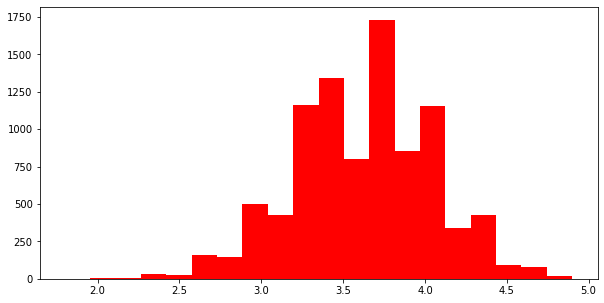

In [29]:
# Plotting the distribution of restaurant ratings
plt.figure(figsize = (10, 5))
plt.hist(newdata.rating, bins = 20, color = "r")
plt.show()


### Observations
- **3.7 is the most common rating**, i.e. most Bangaloreans have above-average dining experiences when they go out. 
- There are very few ratings between 2 to 2.5 and 4.5 to 5, and hardly any under 2.

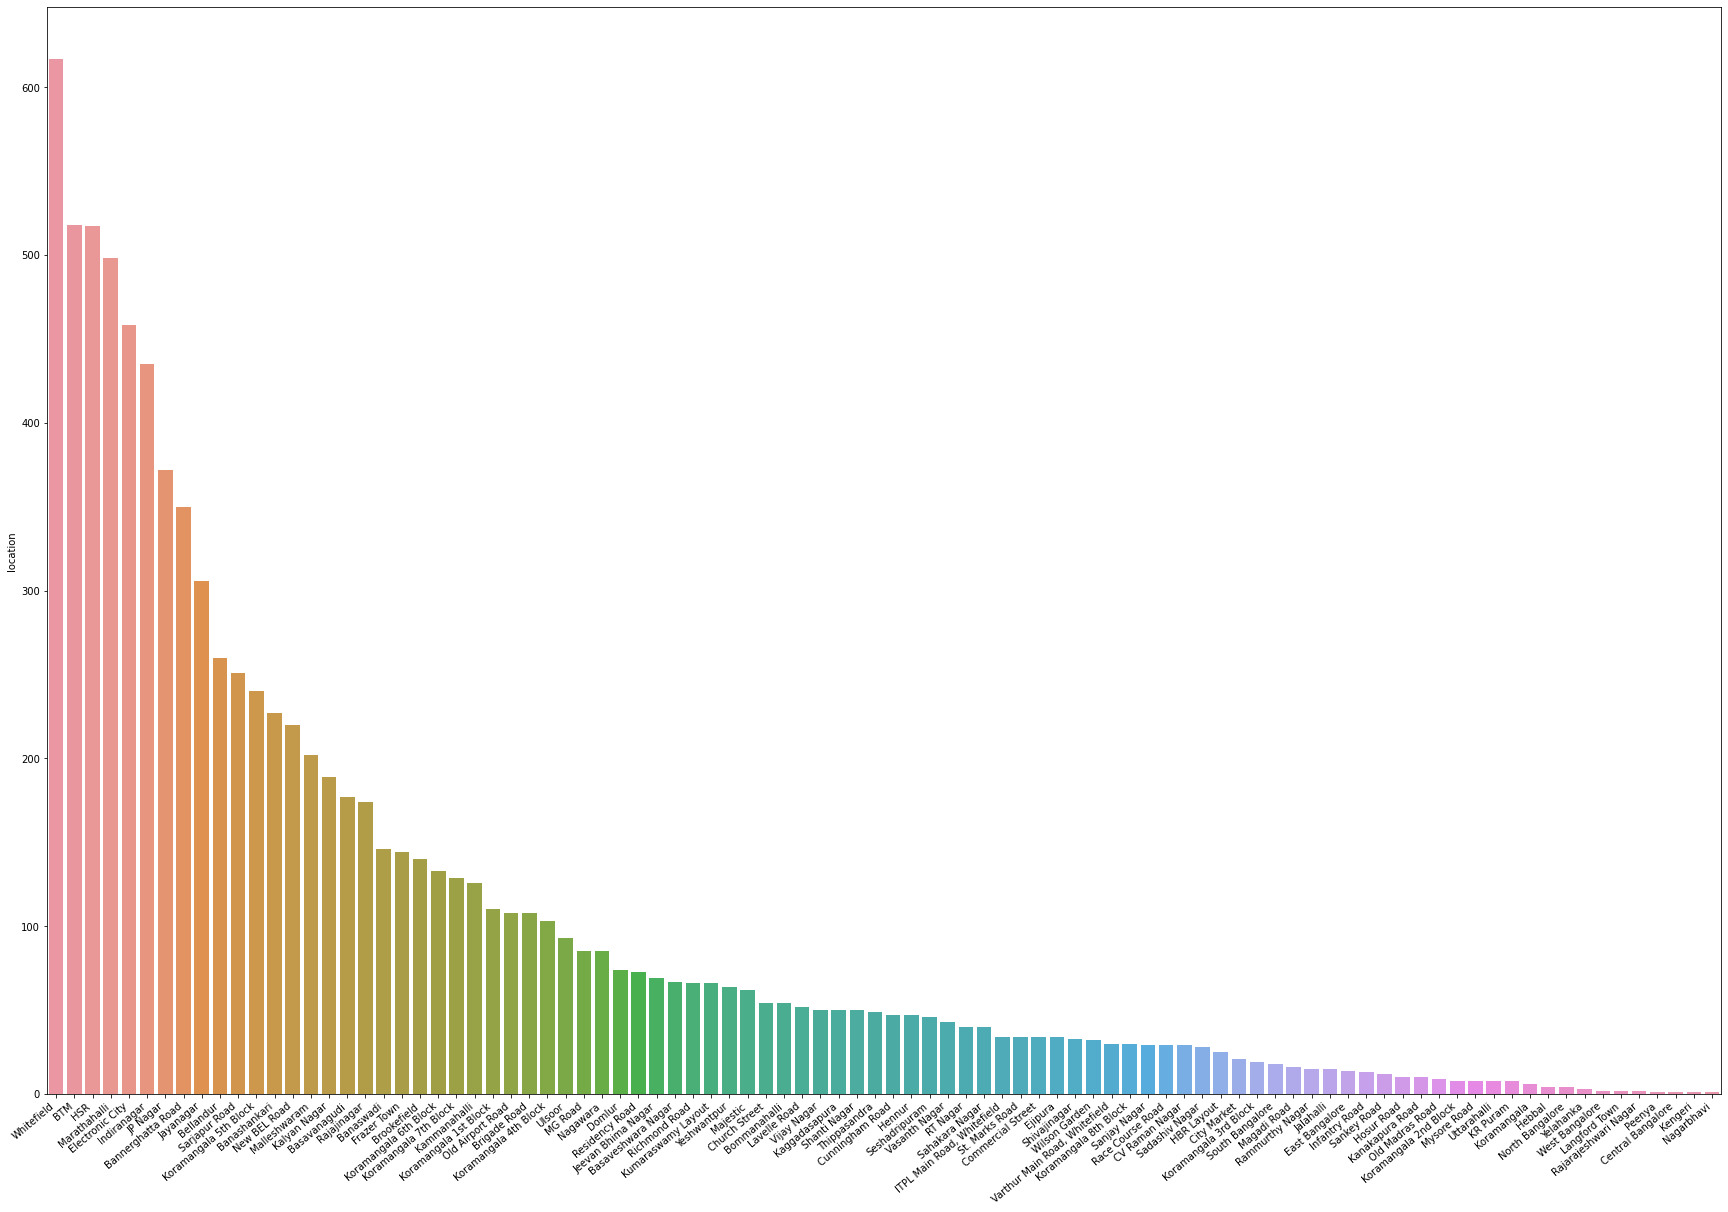

In [30]:
# Plotting the distribution of locations
plt.figure(figsize = (30, 20))
ax = sns.barplot(data = newdata, x = newdata.location.value_counts().index, y = newdata.location.value_counts())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") # to make the labels more readable
plt.show()

In [31]:
# Printing restaurant value counts for the top 25 locations
newdata["location"].value_counts()[:25]

Whitefield               617
BTM                      518
HSR                      517
Marathahalli             498
Electronic City          458
Indiranagar              435
JP Nagar                 372
Bannerghatta Road        350
Jayanagar                306
Bellandur                260
Sarjapur Road            251
Koramangala 5th Block    240
Banashankari             227
New BEL Road             220
Malleshwaram             202
Kalyan Nagar             189
Basavanagudi             177
Rajajinagar              174
Banaswadi                146
Frazer Town              144
Brookefield              140
Koramangala 6th Block    133
Koramangala 7th Block    129
Kammanahalli             126
Koramangala 1st Block    110
Name: location, dtype: int64

### Observations

- After Whitefield, the maximum number of restaurants are in BTM, HSR, Marathahalli and Electronic City
- Koramangala has been split blockwise or it would be at the top with the others


Let's see which locations have the **highest rated** restaurants.

In [32]:
# Top 5 locations with the highest ratings
(pd.DataFrame(newdata.groupby("location")["rating"].mean())).sort_values("rating", ascending = False).head(5)


,rating
location,
Lavelle Road,4.073077
Sankey Road,4.041667
St. Marks Road,3.929412
Koramangala 3rd Block,3.926316
Koramangala 5th Block,3.914167


Which locations are the **most expensive** to dine in?

In [33]:
# Top 5 most expensive locations (cost = cost for two)
(pd.DataFrame(newdata.groupby("location")["cost"].mean())).sort_values("cost", ascending = False).head(5)

,cost
location,
Sankey Road,2695.833333
Lavelle Road,1379.807692
Race Course Road,1331.034483
MG Road,1145.882353
Residency Road,1004.109589


### Observations
- The top two locations with high ratings are also the two most expensive locations (Sankey Road and Lavelle Road)
- In general we can see that restaurants around the MG Road area are more expensive


In [34]:
# Identifying the high rated fancy restaurants on Sankey Road
newdata[(newdata["location"] == "Sankey Road") & (newdata["rating"] >= 4 )]

,online_order,book_table,votes,location,rest_type,cost,rating
name,,,,,,,
Dakshin - ITC Windsor,No,Yes,202,Sankey Road,Fine Dining,4000.0,4.3
Dublin - ITC Windsor,No,Yes,187,Sankey Road,Bar,2500.0,4.1
Dum Pukht Jolly Nabobs - ITC Windsor,No,Yes,291,Sankey Road,Fine Dining,4000.0,4.3
Fabelle Chocolate Boutique - ITC Windsor,No,No,59,Sankey Road,Dessert Parlor,1250.0,4.2
La Brasserie - Le Meridien,No,Yes,309,Sankey Road,Fine Dining,4100.0,4.1
Nandhini Deluxe,No,No,471,Sankey Road,Casual Dining,600.0,4.0
Royal Afghan - ITC Windsor,No,Yes,413,Sankey Road,Fine Dining,5000.0,4.3
The Raj Pavilion - ITC Windsor,No,Yes,371,Sankey Road,Fine Dining,2400.0,4.2


Almost all of them are located in one 5 star hotel!

What about Lavelle Road?

In [35]:
newdata[(newdata["location"] == "Lavelle Road") & (newdata["rating"] >= 4 )][:10]

,online_order,book_table,votes,location,rest_type,cost,rating
name,,,,,,,
Airlines Hotel,Yes,No,867,Lavelle Road,Quick Bites,400.0,4.0
Alba - JW Marriott Bengaluru,No,Yes,583,Lavelle Road,Fine Dining,4000.0,4.5
Amande Patisserie,Yes,No,231,Lavelle Road,"Bakery, Dessert Parlor",300.0,4.2
BBQ'D - Global Grill & Brewery,No,No,471,Lavelle Road,"Casual Dining, Microbrewery",1500.0,4.3
Bengaluru Baking Company - JW Marriott Bengaluru,No,No,521,Lavelle Road,"Bakery, Cafe",1400.0,4.3
Bootlegger,No,No,1543,Lavelle Road,Pub,1200.0,4.1
Cafe Coffee Day The Square,No,No,388,Lavelle Road,Cafe,1100.0,4.1
Cafe Mangii,Yes,Yes,1048,Lavelle Road,Casual Dining,1600.0,4.3
Cafe Noir,No,Yes,2074,Lavelle Road,Casual Dining,1500.0,4.2


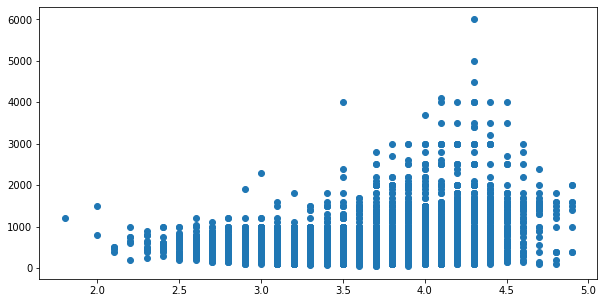

In [36]:
# Visualizing the relationship between rating and cost
plt.figure(figsize = (10, 5))
plt.scatter(newdata.rating, newdata.cost)
plt.show()

### Observations
Interestingly, restaurants rated between 4.5 and 5.0 are **cheaper** than those rated between 4.0 and 4.5.

We have explored and cleaned the dataset and can now apply preprocessing steps that are necessary for model-building.


## Data preprocessing

In [37]:
# Separating the predictors and target
predictors = newdata.drop("rating", axis = 1)
target = newdata["rating"]

In [38]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 0, test_size = 0.3)

In [39]:
# Preprocessing the predictors
num_cols = ["votes", "cost"]
cat_cols = ["location", "rest_type", "online_order", "book_table"]

num_imputer = SimpleImputer(strategy = "median") 
# Imputing numeric columns with the median (not mean because of the high variance)
num_imputed = num_imputer.fit_transform(X_train[num_cols])
scaler = StandardScaler()
# Scaling the numeric columns to have a mean of 0 and standard deviation of 1
num_preprocessed = pd.DataFrame(scaler.fit_transform(num_imputed), columns = num_cols)

cat_imputer = SimpleImputer(strategy = "most_frequent")
# Imputing categorical columns with the mode
cat_imputed = pd.DataFrame(cat_imputer.fit_transform(X_train[cat_cols]), columns = cat_cols)
# Dummifying the categorical columns
cat_preprocessed = pd.DataFrame(pd.get_dummies(cat_imputed, prefix = cat_cols, drop_first = True))


In [40]:
# Joining the numeric and categorical columns and checking their shape
predictors = pd.concat([num_preprocessed, cat_preprocessed], axis=1)

After building one regression model I had found that one feature ("rest_type_Quick Bites") had a high VIF of 12, indicating multicollinearity. We will drop this feature from our predictors.

In [41]:
# Dropping the feature with a high VIF 
predictors.drop("rest_type_Quick Bites", axis = 1, inplace = True)
predictors.shape

(6521, 170)

In [42]:
Y = list(y_train)

## Model Building

In [43]:
# Building an Ordinary Least Squares regression model
import statsmodels.api as sm
X = sm.add_constant(predictors)
ols = sm.OLS(Y, X).fit()

In [44]:
# Predicting on the train data
pred_train = np.around(ols.predict(X), 1)
pred_train[:5] # checking the first 5 predictions

0    3.5
1    3.7
2    3.8
3    3.5
4    3.4
dtype: float64

In [45]:
# Preprocessing the test data and predicting on it
test_num_imputed = num_imputer.transform(X_test[num_cols])
test_num_preprocessed = pd.DataFrame(scaler.transform(test_num_imputed), columns = num_cols)

test_cat_imputed = pd.DataFrame(cat_imputer.transform(X_test[cat_cols]), columns = cat_cols)
test_cat_preprocessed = pd.DataFrame(pd.get_dummies(test_cat_imputed, prefix = cat_cols))

test_predictors = pd.concat([test_num_preprocessed, test_cat_preprocessed], axis=1)
test_predictors.drop("rest_type_Quick Bites", axis = 1, inplace = True)

# Accounting for missing columns in the test set caused by dummification
missing_cols = set(predictors) - set(test_predictors)
# Adding missing columns to test set with default value equal to 0
for c in missing_cols:
    test_predictors[c] = 0
# Ensuring the order of column in the test set is in the same order than in train set
test_predictors = test_predictors[predictors.columns]

test_X = sm.add_constant(test_predictors)
test_Y = list(y_train)

# Prediction
pred_test = np.around(ols.predict(test_X), 1)
pred_test[:5] # first five rating predictions

0    4.0
1    3.9
2    3.7
3    3.8
4    3.5
dtype: float64

### Evaluation

In [46]:
mean_squared_error(y_train, pred_train)

0.12937586259776107

In [47]:
mean_squared_error(y_test, pred_test)

0.1332808586762075

In [48]:
# Finding the Mean Absolute Percentage Error
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape(y_train, pred_train)

8.129189649556416

In [49]:
mape(y_test, pred_test)

8.195894047787434

In [50]:
# Regression with XGBoost
xgb = XGBRegressor(n_estimators = 25000, max_depth = 5, gamma = 0.5, colsample_bytree = 0.8, random_state = 42333)
xgb.fit(predictors, y_train)

pred_train = xgb.predict(predictors)
pred_test = xgb.predict(test_predictors)

[12:35:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [51]:
mean_squared_error(y_train, pred_train)

0.0942740502266156

In [52]:
mean_squared_error(y_test, pred_test)

0.10576529524871363

In [53]:
mape(y_train, pred_train)

6.652958115098677

In [54]:
mape(y_test, pred_test)

6.995497252022008

#Feature Importance

In [69]:
xgb.get_booster().get_score(importance_type="gain")

{'book_table_Yes': 3.1646958317222222,
 'cost': 2.3773386154726044,
 'location_Banaswadi': 1.4000473050000002,
 'location_Bannerghatta Road': 0.9692485340000002,
 'location_Basavanagudi': 0.37173662162500004,
 'location_Bellandur': 0.8709976137777778,
 'location_Bommanahalli': 0.9307069310588236,
 'location_Brigade Road': 0.71695920323,
 'location_Brookefield': 0.569468588,
 'location_Church Street': 0.628009796,
 'location_City Market': 0.21898587800000002,
 'location_Domlur': 0.6090598085,
 'location_East Bangalore': 0.292663116,
 'location_Ejipura': 0.584129333,
 'location_Electronic City': 0.7872271692,
 'location_Frazer Town': 0.24123486366666666,
 'location_HBR Layout': 0.2650352956,
 'location_HSR': 0.342127323,
 'location_Hennur': 0.4811168956666667,
 'location_Hosur Road': 0.138277777,
 'location_ITPL Main Road, Whitefield': 0.31237297059999997,
 'location_Indiranagar': 0.5468204919999999,
 'location_JP Nagar': 0.648019791,
 'location_Jayanagar': 0.5735514238999999,
 'location